In [1]:
#引入套件
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

In [2]:
#加載並整理資料集
(X_train, y_train0), (X_test, y_test0) = datasets.mnist.load_data()
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

In [3]:
# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

In [4]:
#建立VAE模型
enc_1 = Dense(100, activation='sigmoid') 
enc_2 = Dense(235, activation='relu') 
enc_3 = Dense(235, activation='sigmoid') 
enc_mean = Dense(2)
enc_log_var = Dense(2)
dec_3 = Dense(150, activation='sigmoid') 
dec_2 = Dense(350, activation='sigmoid') 
dec_1 = Dense(784, activation='sigmoid') 

In [5]:
a = Input(shape=(784,))
enc_x = enc_3(enc_2(enc_1(a)))

y_mean = enc_mean(enc_x)
y_log_var = enc_log_var(enc_x)

In [6]:
def sampling(args):
    y_mean, y_log_var = args
    batch = K.shape(y_mean)[0]
    dim = K.int_shape(y_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return y_mean + K.exp(0.5 * y_log_var) * epsilon   

In [7]:
# Sampling function wrapped as a Keras layer
y = Lambda(sampling, output_shape=(2,))([y_mean, y_log_var])

In [8]:
# Define Decoder part of VAE
y_input = Input(shape=(2,))
x_hat = dec_1(dec_2(dec_3(y_input)))

In [11]:
x_hat = dec_1(dec_2(dec_3(y)))
VAE = Model(a, x_hat)
VAE.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          78500       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 235)          23735       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 235)          55460       dense_1[0][0]                    
______________________________________________________________________________________________

In [13]:
#Loss函數
reconstruction_loss = 784 * losses.mean_squared_error(a, x_hat)

kl_loss = 1 + y_log_var - K.square(y_mean) - K.exp(y_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

In [14]:
VAE.compile(optimizer=Adam())

In [15]:
#訓練
VAE.fit(X_train, 
        batch_size=512, 
        epochs=20)

Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 40us/sample - loss: 58.7828
Epoch 2/20
60000/60000 [==============================] - 2s 33us/sample - loss: 52.8288
Epoch 3/20
60000/60000 [==============================] - 2s 37us/sample - loss: 52.8216
Epoch 4/20
60000/60000 [==============================] - 2s 38us/sample - loss: 52.8233
Epoch 5/20
60000/60000 [==============================] - 2s 38us/sample - loss: 52.3302
Epoch 6/20
60000/60000 [==============================] - 2s 37us/sample - loss: 49.5435
Epoch 7/20
60000/60000 [==============================] - 2s 39us/sample - loss: 48.6356
Epoch 8/20
60000/60000 [==============================] - 2s 36us/sample - loss: 48.0322
Epoch 9/20
60000/60000 [==============================] - 2s 36us/sample - loss: 47.7418
Epoch 10/20
60000/60000 [==============================] - 3s 46us/sample - loss: 47.4122
Epoch 11/20
60000/60000 [==============================] - 3s 50us/sample - loss: 46.9

In [19]:
VAE_Encoder = Model(a, y_mean)

VAE_Encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 235)               23735     
_________________________________________________________________
dense_2 (Dense)              (None, 235)               55460     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 472       
Total params: 158,167
Trainable params: 158,167
Non-trainable params: 0
_________________________________________________________________


In [20]:
VAE_Decoder = Model(y_input, dec_1(dec_2(dec_3(y_input))))

VAE_Decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 150)               450       
_________________________________________________________________
dense_6 (Dense)              (None, 350)               52850     
_________________________________________________________________
dense_7 (Dense)              (None, 784)               275184    
Total params: 328,484
Trainable params: 328,484
Non-trainable params: 0
_________________________________________________________________


In [21]:
idx = np.random.randint(X_train.shape[0])
print(f"第 {idx} 圖的 latent 表示為 {VAE_Encoder.predict(X_train[idx: idx+1]).squeeze()}")

第 3384 圖的 latent 表示為 [-0.39368686  0.49111757]


In [22]:
indices = np.random.randint(X_train.shape[0], size=3000)

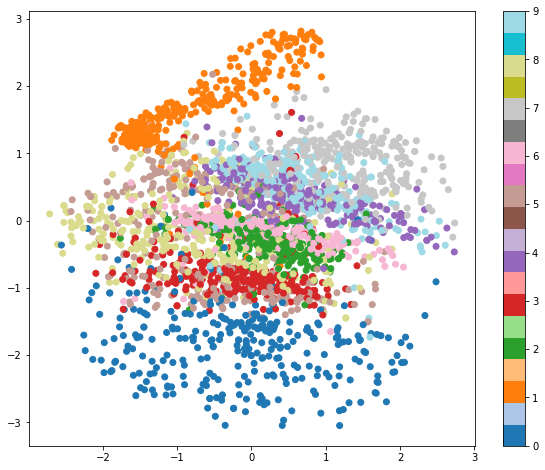

In [26]:
#視覺化_Encoder
VAE_latents = VAE_Encoder.predict(X_train[indices])
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

In [27]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [28]:
n = 18
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

In [29]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

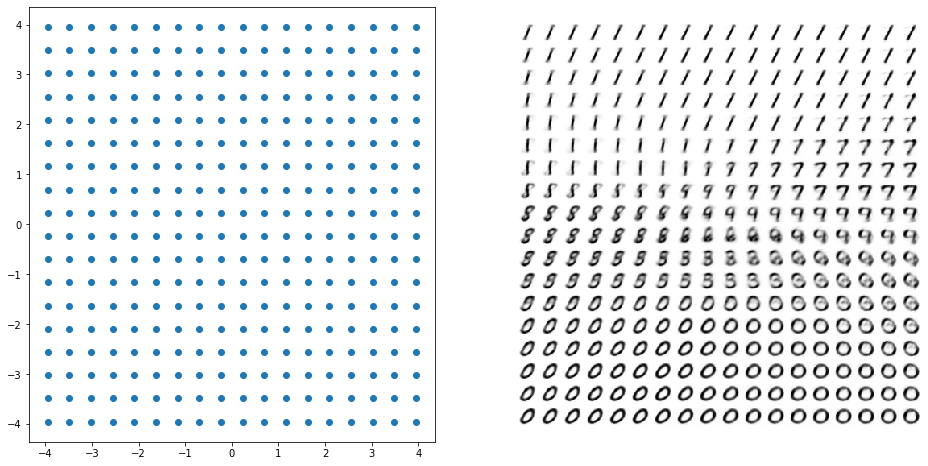

In [30]:
#視覺化_Decoder
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

In [31]:
#動態比較
idx_1, idx_2 = np.random.randint(X_train.shape[0], size=2)

In [32]:
def inBetween(t):
    data_0 = X_train[idx_1].reshape(28, 28)
    data_1 = X_train[idx_2].reshape(28, 28)
    data_t = (1-t)*data_0 + t*data_1
    
    mu_0 = VAE_Encoder.predict(X_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(X_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')
    ax2.set_title('t=0')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')
    ax3.set_title(f't={t}')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    ax4.set_title('t=1')

In [33]:
interact(inBetween, t=FloatSlider(value=0, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>